In [ ]:
#!/usr/bin/env python
#coding: utf-8


In [318]:

#Importing modules

get_ipython().system('pip install geopandas')
get_ipython().system('pip install scikit-learn')
get_ipython().system('pip install datetime')
import geopandas as gpd
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import numpy as np
from datetime import datetime
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
import json
import matplotlib.pyplot as plt
import collections






[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: pip install --upgrade pip


In [166]:
## Read jsons
train_df1 = gpd.read_file('train.geojson', index_col='index')
test_df1 = gpd.read_file('test.geojson', index_col='index')

/Users/samuelmoyal/Documents/DD/MiT/Mban/Interviews/Projet_datascience/env/lib/python3.13/site-packages/pyogrio/raw.py:198: RuntimeWarning: driver GeoJSON does not support open option INDEX_COL
  return ogr_read(


In [365]:
#Labelling outputs
change_type_map = {'Demolition': 0, 'Road': 1, 'Residential': 2, 'Commercial': 3, 'Industrial': 4,
       'Mega Projects': 5}

In [366]:
train_y = train_df1['change_type'].apply(lambda x: change_type_map[x])


['Dense Urban', 'Sparse Urban', 'Industrial', 'N,A', 'Rural', 'Sparse Urban,Industrial', 'Dense Urban,Industrial', 'Sparse Urban,Urban Slum', 'Urban Slum', 'Dense Urban,Urban Slum']
[89427, 69189, 60411, 36682, 20428, 8129, 7223, 1948, 1472, 669]


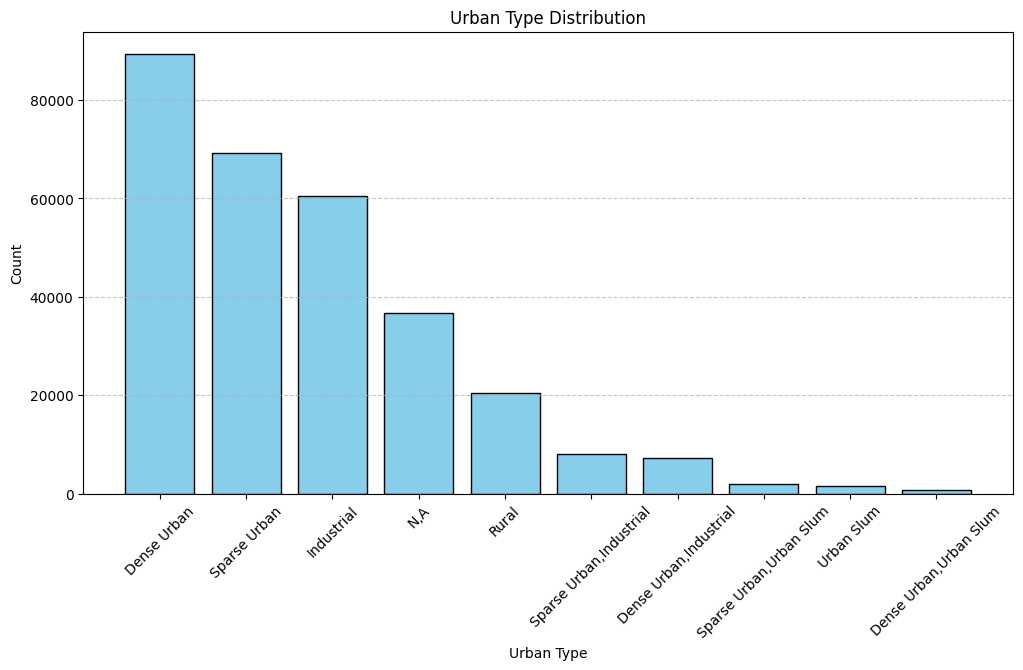

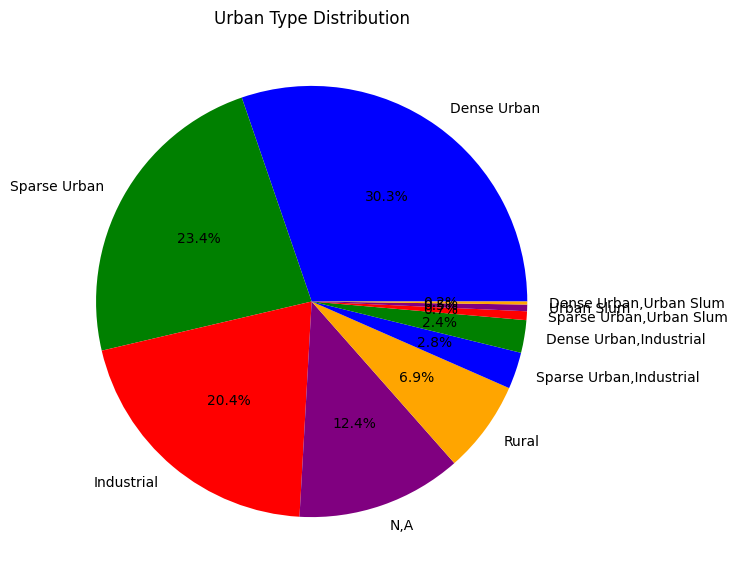

In [367]:

train_dataset = train_df1

# Extract urban types
urban_types = train_dataset["urban_type"]

# Manual counting without collections.Counter
urban_counts = {}
for urban_type in urban_types:
    if urban_type in urban_counts:
        urban_counts[urban_type] += 1
    else:
        urban_counts[urban_type] = 1

# Convert to lists for plotting
urban_labels = list(urban_counts.keys())
urban_values = list(urban_counts.values())

urban_values_sorted,urban_labels_sorted = zip(*sorted(zip(urban_values, urban_labels)))
urban_labels_sorted = list(urban_labels_sorted)
urban_values_sorted = list(urban_values_sorted)

urban_labels_sorted.reverse()
urban_values_sorted.reverse()

urban_labels_sorted=urban_labels_sorted[:10]
urban_values_sorted=urban_values_sorted[:10]

# --- BAR CHART ---
plt.figure(figsize=(12, 6))
plt.bar(urban_labels_sorted, urban_values_sorted, color='skyblue', edgecolor='black')
plt.xlabel("Urban Type")
plt.ylabel("Count")
plt.title("Urban Type Distribution")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# --- PIE CHART ---
plt.figure(figsize=(7, 7))
plt.pie(urban_values_sorted, labels=urban_labels_sorted, autopct='%1.1f%%', colors=["blue", "green", "red", "purple", "orange"])
plt.title("Urban Type Distribution")
plt.show()


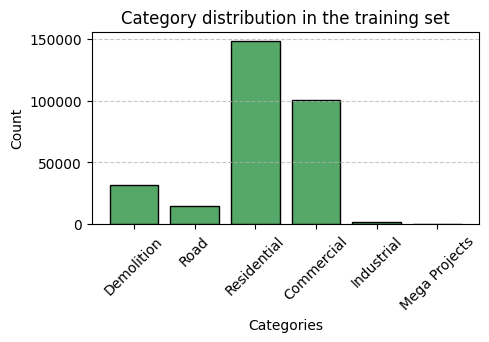

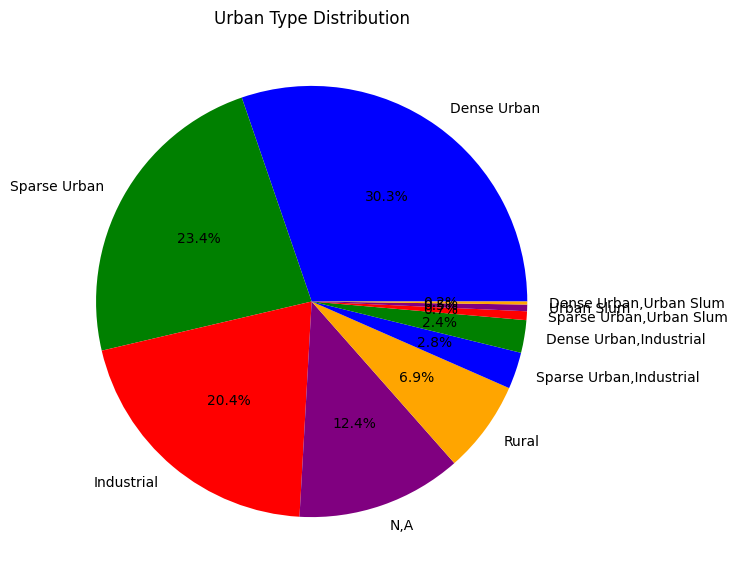

In [459]:
train_dataset = train_df1

# Extract change types
change_types = train_dataset["change_type"]

#print(urban_types)

# Manual counting without collections.Counter
change_counts = {}
for change_type in change_types:
    if change_type in change_counts:
        change_counts[change_type] += 1
    else:
        change_counts[change_type] = 1

# Convert to lists for plotting
change_labels = list(change_counts.keys())
change_labels_sorted = [change_labels[1], change_labels[0] , change_labels[3] , change_labels[2]   , change_labels[4]   , change_labels[5] ]
change_values = list(change_counts.values())
change_values_sorted = [change_values[1], change_values[0] , change_values[3] , change_values[2]   , change_values[4]   , change_values[5] ]


# --- BAR CHART ---
plt.figure(figsize=(5, 2.5))
plt.bar(change_labels_sorted, change_values_sorted, color='#55A868', edgecolor='black')
plt.xlabel("Categories")
plt.ylabel("Count")
plt.title("Category distribution in the training set")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# --- PIE CHART ---
plt.figure(figsize=(7, 7))
plt.pie(urban_values_sorted, labels=urban_labels_sorted, autopct='%1.1f%%', colors=["blue", "green", "red", "purple", "orange"])
plt.title("Urban Type Distribution")
plt.show()

In [369]:
#Creating an independent copy of the original dataset to work on.
train_df = train_df1.copy()
test_df = test_df1.copy()

 # Feature engineering

In [370]:

# One-Hot Encoding of urban-type:
types_de_zones_urbaines = ['Sparse Urban', 'Rural', 'Dense Urban', 'Industrial','Urban Slum','N,A']
# Création of a feature for each element of urban-type
for zone in types_de_zones_urbaines:
    train_df[zone] = train_df.urban_type.map(lambda x: 1 if zone in x else 0)
    test_df[zone] = test_df.urban_type.map(lambda x: 1 if zone in x else 0)

In [219]:
#Label Encoding with number proportional to the degre of construction 
types_de_status= {'Construction Started':0,'Land Cleared':1 , 'Prior Construction':2,'Operational':3,'Construction Midway':4,'Greenland':5,'Excavation':6,'Construction Done':7, 'Materials Dumped':8, 'Materials Introduced':9,None:10}

train_df.change_status_date0 = train_df.change_status_date0.map(types_de_status)
train_df.change_status_date1 = train_df.change_status_date1.map(types_de_status)
train_df.change_status_date2 = train_df.change_status_date2.map(types_de_status)
train_df.change_status_date3 = train_df.change_status_date3.map(types_de_status)
train_df.change_status_date4 = train_df.change_status_date4.map(types_de_status)

test_df.change_status_date0 = test_df.change_status_date0.map(types_de_status)
test_df.change_status_date1 = test_df.change_status_date1.map(types_de_status)
test_df.change_status_date2 = test_df.change_status_date2.map(types_de_status)
test_df.change_status_date3 = test_df.change_status_date3.map(types_de_status)
test_df.change_status_date4 = test_df.change_status_date4.map(types_de_status)



In [372]:
train_df = train_df[train_df['geography_type'] != 'N,A']
test_df = test_df[test_df['geography_type'] != 'N,A']

289963


In [373]:
types_de_geographies = []
for str in train_df.geography_type :
    values = str.split(',')
    for k in values:
        if k not in types_de_geographies:
            types_de_geographies.append(k)
            
for geographie in types_de_geographies:
    train_df[geographie] = train_df.geography_type.map(lambda x: 1 if geographie in x else 0)
    test_df[geographie] = test_df.geography_type.map(lambda x: 1 if geographie in x else 0)




In [375]:
train_df.geometry=train_df.geometry.to_crs(epsg=3857)

In [377]:

types_de_status = {
    'Construction Started': 0, 'Land Cleared': 1, 'Prior Construction': 2, 'Operational': 3,
    'Construction Midway': 4, 'Greenland': 5, 'Excavation': 6, 'Construction Done': 7,
    'Materials Dumped': 8, 'Materials Introduced': 9, None: 10
}

# Extract date columns
date_columns = [col for col in train_df.columns if col.startswith("date")]
status_columns = [col.replace("date", "change_status_date") for col in date_columns]  # Get corresponding status columns

# Convert dates to datetime if not already
for col in date_columns:
    train_df[col] = pd.to_datetime(train_df[col], format='%d-%m-%Y')
    test_df[col] = pd.to_datetime(test_df[col], format='%d-%m-%Y')

# Apply the same sorting order to both date columns and change_status columns
for df in [train_df, test_df]:
    sorted_indices = np.argsort(df[date_columns].values, axis=1)  # Get sorted indices per row
    
    # Sort dates
    df[date_columns] = np.take_along_axis(df[date_columns].values, sorted_indices, axis=1)

    # Encode change_status before sorting
    for col in status_columns:
        df[col] = df[col].map(types_de_status)

    # Sort change_status based on the same indices as dates
    df[status_columns] = np.take_along_axis(df[status_columns].values, sorted_indices, axis=1)
# Convert sorted dates to numeric timestamps (days since Jan 1, 2000)
for col in date_columns:
    train_df[col] = (train_df[col] - pd.Timestamp("2000-01-01")) // pd.Timedelta('1D')
    test_df[col] = (test_df[col] - pd.Timestamp("2000-01-01")) // pd.Timedelta('1D')

# Time difference

train_df['diff_date1_date0'] = train_df['date1'] - train_df['date0']
train_df['diff_date2_date1'] = train_df['date2'] - train_df['date1']
train_df['diff_date3_date2'] = train_df['date3'] - train_df['date2']
train_df['diff_date4_date3'] = train_df['date4'] - train_df['date3']

test_df['diff_date1_date0'] = test_df['date1'] - test_df['date0']
test_df['diff_date2_date1'] = test_df['date2'] - test_df['date1']
test_df['diff_date3_date2'] = test_df['date3'] - test_df['date2']
test_df['diff_date4_date3'] = test_df['date4'] - test_df['date3']

#Creation of features about the geometry

train_df['area'] = train_df[['geometry']].area
train_df['perimeter'] = train_df['geometry'].length
train_df['area/perimeter'] = train_df[['geometry']].area / (train_df['geometry'].length)
train_df['area/perimeter**2'] = train_df[['geometry']].area / (train_df['geometry'].length)**2

test_df['area'] = test_df[['geometry']].area
test_df['perimeter'] = test_df['geometry'].length
test_df['area/perimeter'] = test_df[['geometry']].area / (test_df['geometry'].length)
test_df['area/perimeter**2'] = test_df[['geometry']].area / (test_df['geometry'].length)**2


#  Différence entre les canaux et les niveaux de gris pour chaque date
for date in range(1, 5):
    # différence pour chaque canal RVB
    train_df[f'diff_red_date{date}'] = train_df[f'img_red_mean_date{date+1}'] - train_df[f'img_red_mean_date{date}']
    train_df[f'diff_green_date{date+1}'] = train_df[f'img_green_mean_date{date+1}'] - train_df[f'img_green_mean_date{date}']
    train_df[f'diff_blue_date{date+1}'] = train_df[f'img_blue_mean_date{date+1}'] - train_df[f'img_blue_mean_date{date}']
    #train_df[f'diff_gray_date{date+1}'] = train_df[f'grayscale_date{date+1}'] - train_df[f'grayscale_date{date}']
    train_df[f'diff_red_std_date{date}'] = train_df[f'img_red_std_date{date+1}'] - train_df[f'img_red_std_date{date}']
    train_df[f'diff_green_std_date{date+1}'] = train_df[f'img_green_std_date{date+1}'] - train_df[f'img_green_std_date{date}']
    train_df[f'diff_blue_std_date{date+1}'] = train_df[f'img_blue_std_date{date+1}'] - train_df[f'img_blue_std_date{date}']
    
    test_df[f'diff_red_date{date}'] = test_df[f'img_red_mean_date{date+1}'] - test_df[f'img_red_mean_date{date}']
    test_df[f'diff_green_date{date+1}'] = test_df[f'img_green_mean_date{date+1}'] - test_df[f'img_green_mean_date{date}']
    test_df[f'diff_blue_date{date+1}'] = test_df[f'img_blue_mean_date{date+1}'] - test_df[f'img_blue_mean_date{date}']
    #test_df[f'diff_gray_date{date+1}'] = test_df[f'grayscale_date{date+1}'] - test_df[f'grayscale_date{date}']
    test_df[f'diff_red_std_date{date}'] = train_df[f'img_red_std_date{date+1}'] - train_df[f'img_red_std_date{date}']
    test_df[f'diff_green_std_date{date+1}'] = train_df[f'img_green_std_date{date+1}'] - train_df[f'img_green_std_date{date}']
    test_df[f'diff_blue_std_date{date+1}'] = train_df[f'img_blue_std_date{date+1}'] - train_df[f'img_blue_std_date{date}']





/Users/samuelmoyal/Documents/DD/MiT/Mban/Interviews/Projet_datascience/env/lib/python3.13/site-packages/shapely/measurement.py:44: RuntimeWarning: invalid value encountered in area
  return lib.area(geometry, **kwargs)
/Users/samuelmoyal/Documents/DD/MiT/Mban/Interviews/Projet_datascience/env/lib/python3.13/site-packages/shapely/measurement.py:182: RuntimeWarning: invalid value encountered in length
  return lib.length(geometry, **kwargs)
/Users/samuelmoyal/Documents/DD/MiT/Mban/Interviews/Projet_datascience/env/lib/python3.13/site-packages/shapely/measurement.py:44: RuntimeWarning: invalid value encountered in area
  return lib.area(geometry, **kwargs)
/Users/samuelmoyal/Documents/DD/MiT/Mban/Interviews/Projet_datascience/env/lib/python3.13/site-packages/shapely/measurement.py:182: RuntimeWarning: invalid value encountered in length
  return lib.length(geometry, **kwargs)
/Users/samuelmoyal/Documents/DD/MiT/Mban/Interviews/Projet_datascience/env/lib/python3.13/site-packages/shapely/me

In [378]:
# Suppression of features
    
colonnes_a_supprimer = ['urban_type', 'geography_type','change_type',
                        'geometry','index','date0','date1','date2','date3','date4']


train_df.drop(colonnes_a_supprimer, axis=1, inplace=True)
colonnes_a_supprimer.remove('change_type')

test_df.drop(colonnes_a_supprimer, axis=1, inplace=True)


In [380]:
train_df = train_df.dropna()


286647


In [382]:
train_y = train_y.loc[train_df.index]

# Reset indices to keep alignment clean
train_df = train_df.reset_index(drop=True)
train_y = train_y.reset_index(drop=True)


In [ ]:
#  NA replaced by the mean of the feature
for colonne in train_df.columns[train_df.isna().any()]:
    train_df[colonne].fillna(train_df[colonne].mean() ,inplace = True)

for colonne in test_df.columns[test_df.isna().any()]:
    test_df[colonne].fillna(test_df[colonne].mean() ,inplace = True)


In [ ]:
train_df = train_df.astype(float)
test_df = test_df.astype(float)

In [ ]:
# ## Normalization of train

mean_data = train_df.mean()
std_data = train_df.std()
normalized_train_df = train_df.apply(lambda x: (x - mean_data)/std_data , axis =1)

In [ ]:
mean_data = test_df.mean()
std_data = test_df.std()
normalized_test_df = test_df.apply(lambda x: (x - mean_data)/std_data , axis =1)


In [ ]:
# ##  LDA
train_df_LDA = train_df
train_y_LDA = train_y

lda = LDA(n_components=5)  # Choisir le nombre de composantes
X_trainlda = lda.fit_transform(train_df_LDA, train_y_LDA)
X_trainlda_df = pd.DataFrame(X_trainlda)

In [ ]:
#LDA
X_testlda = lda.transform(test_df)
X_testlda_df = pd.DataFrame(X_testlda)

In [ ]:
# ## PCA
train_df_PCA = normalized_train_df

#PCA on train data
pca = PCA().fit(train_df_PCA)
variance_cumulee = np.cumsum(pca.explained_variance_ratio_)
# 95% of variance kept
num_components = np.where(variance_cumulee >= 0.95)[0][0] + 1
pca = PCA(n_components=num_components)
df_PCA = pca.fit_transform(train_df_PCA)
df_PCA = pd.DataFrame(df_PCA)
df_PCA.to_csv("TrainDataAfterPCA-95%.csv", index=False)

In [ ]:
test_df_PCA = normalized_test_df
df_test_PCA = pca.transform(test_df_PCA)
df_test_PCA = pd.DataFrame(df_test_PCA)

In [ ]:
# Initialisation 
model =KNeighborsClassifier(n_neighbors=4)
num_folds = 5
kfold = KFold(n_splits=num_folds)
scores = cross_val_score(model,train_df, train_y, cv=kfold)

print("Scores de chaque pli:", scores)
mean_score = scores.mean()
print("Score moyen de validation croisée:", mean_score)

In [ ]:
# ### Prévision 
neigh = KNeighborsClassifier(n_neighbors=4)
neigh.fit(df_PCA, train_y) #ici c est avec PCA mais on peut aussi faire avec LDA
pred_y_KNN = neigh.predict(df_test_PCA)

In [ ]:

answer_df = pd.DataFrame(pred_y_KNN, columns = ['change_type'])
answer_df.index.name = 'Id'
answer_df.to_csv('answer.csv')


In [ ]:
model =SVC(kernel='rbf')
num_folds = 5
kfold = KFold(n_splits=num_folds)
scores = cross_val_score(model,df_PCA, train_y, cv=kfold)

print("Scores de chaque pli:", scores)
mean_score = scores.mean()
print("Score moyen de validation croisée:", mean_score)


In [ ]:
# ### LDA-cross validation

model =SVC(kernel='rbf')
num_folds = 5

kfold = KFold(n_splits=num_folds)
scores = cross_val_score(model,X_trainlda_df, train_y, cv=kfold)

print("Scores de chaque pli:", scores)
mean_score = scores.mean()
print("Score moyen de validation croisée:", mean_score)

In [ ]:
svm_model = SVC(kernel='rbf')
svm_model.fit(df_PCA, train_y) 

y_pred = svm_model.predict(df_test_PCA)
y_train_pred = svm_model.predict(df_PCA)

train_accuracy = accuracy_score(train_y, y_train_pred)
print("Précision du modèle SVM sur les données d'entraînement:", train_accuracy)

In [ ]:
answer_SVM = pd.DataFrame(y_pred, columns = ['change_type'])
answer_SVM.index.name = 'Id'
answer_SVM.to_csv('answer.csv')

In [301]:
model =RandomForestClassifier(n_estimators=25, max_depth=20, min_samples_leaf=5,max_features="sqrt", random_state=42)

In [114]:
num_folds = 5
kfold = KFold(n_splits=num_folds)
scores = cross_val_score(model,train_df, train_y, cv=kfold)
print("Scores de chaque pli:", scores)
mean_score = scores.mean()
print("Score moyen de validation croisée:", mean_score)



Scores de chaque pli: [0.61903949 0.63632327 0.61102951 0.603064   0.63903264]
Score moyen de validation croisée: 0.6216977800814105


In [383]:
model.fit(train_df, train_y)

# Get feature importance scores
importances = model.feature_importances_

# Create DataFrame for better visualization
feature_names = train_df.columns  # Assuming X_train is a DataFrame
importance_df = pd.DataFrame({"Feature": feature_names, "Importance": importances})
importance_df = importance_df.sort_values(by="Importance", ascending=False)

                Feature  Importance
34  change_status_date4    0.117844
59    area/perimeter**2    0.063474
57            perimeter    0.059790
56                 area    0.041852
58       area/perimeter    0.039811
30  change_status_date0    0.032566
33  change_status_date3    0.029991
54     diff_date3_date2    0.024317
31  change_status_date1    0.024090
53     diff_date2_date1    0.023033


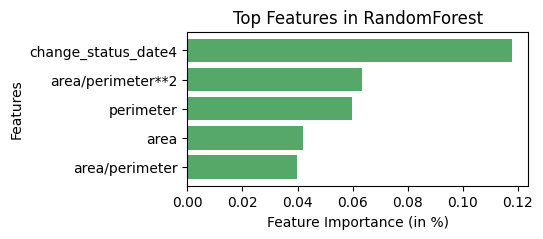

In [457]:
plt.figure(figsize=(4.4, 2))
plt.barh(importance_df["Feature"][:5], importance_df["Importance"][:5], color="#55A868")
plt.xlabel("Feature Importance (in %)")
plt.ylabel("Features")
plt.title("Top Features in RandomForest")
plt.gca().invert_yaxis()  # Highest importance on top
plt.show()


In [296]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_predict


In [302]:

y_pred = cross_val_predict(model, train_df, train_y, cv=5)  # Same CV folds as cross_val_score

In [303]:
# Compute the confusion matrix
conf_matrix = confusion_matrix(train_y, y_pred)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=model.classes_)
disp.plot(cmap="Blues", values_format="d")  # 'd' for integer counts

AttributeError: 'RandomForestClassifier' object has no attribute 'classes_'

In [317]:
from sklearn.metrics import f1_score

# Compute F1-score
f1 = f1_score(train_y, y_pred, average="weighted")  # "weighted" accounts for class imbalance
print("F1-Score:", f1)

F1-Score: 0.8741123979282487


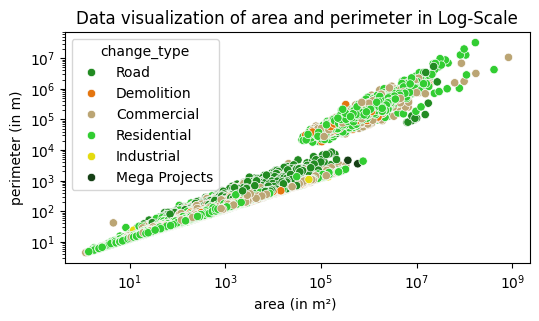

In [458]:
import seaborn as sns
import matplotlib.pyplot as plt


# Define mapping of class labels
class_mapping = {0: "Demolition", 1: "Road", 2: "Residential", 
                 3: "Commercial", 4: "Industrial", 5: "Mega Projects"}



# Convert numerical labels to category names
train_y_named = train_y.map(class_mapping)  # If train_y is a Pandas Series

# Scatterplot of two important features
plt.figure(figsize=(6, 3))
sns.scatterplot(x=train_df["area"], 
                y=train_df["perimeter"], 
                hue=train_y_named,  # Color b y urban type
                palette=["#228B22", "#E4750F",   "#BBA574","#32CD32", "#E4DB0F", "#154015"])
plt.xscale("log")  # Log scale for x-axis
plt.yscale("log")  # Log scale for y-axis

plt.xlabel("area (in m²) ")
plt.ylabel("perimeter (in m)")
plt.title("Data visualization of area and perimeter in Log-Scale")
plt.show()

In [140]:
sns.pairplot(train_df[["area/perimeter**2", "change_status_date1", "change_status_date2", "change_status_date3"]], hue=train_y)
plt.show()

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

286647


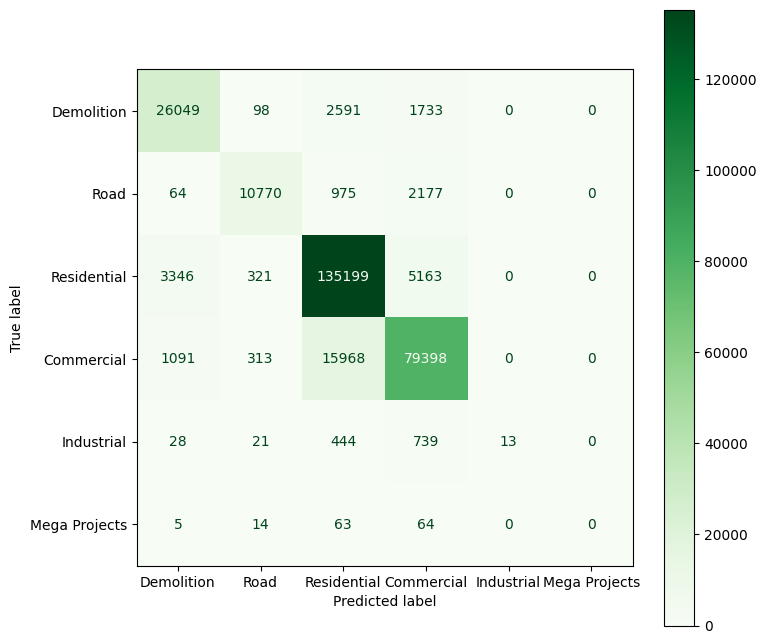

In [455]:
y_pred = model.predict(train_df)
conf_matrix = confusion_matrix(train_y, y_pred)
print(len(train_y))
display_labels=["Demolition","Road", "Residential", "Commercial",  "Industrial", "Mega Projects"]

fig, ax = plt.subplots(figsize=(8, 8))  # Adjust size if needed


disp = ConfusionMatrixDisplay(conf_matrix, display_labels=display_labels)
disp.plot(cmap="Greens", values_format="d", ax=ax)  # 'd' for integer counts


In [340]:
conf_matrix = confusion_matrix(train_y, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", linewidths=0.5, annot_kws={"size": 10})
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

ValueError: Found input variables with inconsistent numbers of samples: [296146, 286647]

In [ ]:
# In[ ]:


rf_model = RandomForestClassifier(n_estimators=50) 
rf_model.fit(train_df, train_y)
y_pred_train=rf_model.predict(train_df)

y_label_train=train_y
y_pred_forest = rf_model.predict(test_df)

accuracy = accuracy_score(y_pred_train, y_label_train)
print("Précision du modèle Random Forest sur les données de test:", accuracy)

print("Précision du modèle Random Forest sur les données d'entraînement:", train_accuracy)



answer_RandFor = pd.DataFrame(y_pred_forest, columns = ['change_type'])

answer_RandFor.index.name = 'Id'

answer_RandFor.to_csv('answer_Rand.csv')